## 4. Clustering of electricity demand time-series

<li> During the EDA stage it was shown that the demand time-series from various meters are shifted in time. Therefore as an appropriate clustering method Dynamic Time Warping (DTW) distances will be computed between all pairwise combinations of time-series and the hierarchical clustering will be applied to these distances. </li> <li> An output will represent the list of clusters and the list of meters which belong to each cluster. </li> <li> To speed up the calculations, clustering algorithm will be applied only for 1-2 years of data from the subset of time-series. </li>

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from dtw import*
import itertools
from scipy.cluster.hierarchy import fcluster,ward,dendrogram,complete
from scipy.spatial.distance import squareform, pdist

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
df = pd.read_pickle('demand_data_for_modelling')
df.head()

,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h
0,1,2005-01-01 00:00:00,3304.0,0.0,0.330996,NaN,NaN
1,1,2005-01-01 01:00:00,3178.0,1.0,0.318373,NaN,NaN
2,1,2005-01-01 02:00:00,2981.0,2.0,0.298638,NaN,NaN
3,1,2005-01-01 03:00:00,2944.0,3.0,0.294931,NaN,NaN
4,1,2005-01-01 04:00:00,2934.0,4.0,0.293929,NaN,NaN


Since demand time-series are shifted in time, the distance between time-series will be computed using Dynamic Time Warping algorithm.

Example: Align two time-series using DTW algorithm
--

In [3]:
ts1 = df[df['meter_id']==1].normalized_demand
ts2 = df[df['meter_id']==2].normalized_demand

In [4]:
?dtw

Signature:
dtw(
    x,
    y=None,
    dist_method='euclidean',
    step_pattern='symmetric2',
    window_type=None,
    window_args={},
    keep_internals=False,
    distance_only=False,
    open_end=False,
    open_begin=False,
)
Docstring:
Compute Dynamic Time Warp and find optimal alignment between two time
series.

**Details**

The function performs Dynamic Time Warp (DTW) and computes the optimal
alignment between two time series ``x`` and ``y``, given as numeric
vectors. The “optimal” alignment minimizes the sum of distances between
aligned elements. Lengths of ``x`` and ``y`` may differ.

The local distance between elements of ``x`` (query) and ``y``
(reference) can be computed in one of the following ways:

1. if ``dist_method`` is a string, ``x`` and ``y`` are passed to the
   `scipy.spatial.distance.cdist` function with the method given;
2. multivariate time series and arbitrary distance metrics can be
   handled by supplying a local-distance matrix. Element ``[i,j]`` of
   

Align and plot two example time-series:

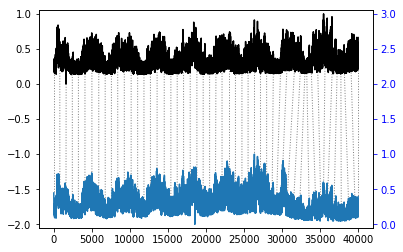

In [5]:
dtw(ts1[0:40000],ts2[0:40000],keep_internals=True).plot(type="twoway", offset=-2)

If more than 40000 data points are passed to the algorithm, kernel dies.

Compute DTW distances for pairwise combinations of time-series from a subset of meters
--

Randomly select 20 meters:

In [6]:
meter_ids = df.meter_id.unique()
#rand_meters = np.random.choice(meter_ids, 20, replace=False)
rand_meters = [10,  51,  52,  60,  81,  86,  89, 104, 113, 157, 209, 362, 400, 412, 419, 422, 446, 453, 472, 481] # Uncomment to use the original selection which is called in other notebooks 

Build pairwise combinations between meters:

In [7]:
ids_pairs = list(itertools.combinations_with_replacement(rand_meters, 2))
ids_pairs[0:5]

[(10, 10), (10, 51), (10, 52), (10, 60), (10, 81)]

Compute a matrix of normalized DTW distances between each pair of time-series for 1 year of data:

We can use the default symmetrical step pattern (https://stats.stackexchange.com/questions/457839/how-can-the-dtw-distance-between-two-curves-be-asymmetric). NormalizedDistance is returned, so we can compare the sequences of different length:

In [8]:
dtw_dist_matrix = {}
n = 24*365*1
for item in ids_pairs:
    ts1 = df[df['meter_id']==item[0]].normalized_demand
    ts2 = df[df['meter_id']==item[1]].normalized_demand
    diff = dtw(ts1[0:n],ts2[0:n],keep_internals=True).normalizedDistance # Uncomment to use a symmetric stepPattern
    dtw_dist_matrix[item] = [diff] 

In [9]:
?symmetric2

Type:        StepPattern
String form:
Step pattern recursion:
 g[i,j] = min(
     g[i-1,j-1] + 2 * d[i  ,j  ] ,
     g[i  ,j-1] +     d[i  ,j  ] ,
     g[i-1,j  ] +     d[i  ,j  ] ,
 ) 

Normalization hint: N+M
File:        ~/anaconda3/envs/exts-ml/lib/python3.6/site-packages/dtw/stepPattern.py
Docstring:  
Step patterns for DTW

A ``stepPattern`` object lists the transitions allowed while searching
for the minimum-distance path. DTW variants are implemented by passing
one of the objects described in this page to the ``stepPattern``
argument of the [dtw()] call.

**Details**

A step pattern characterizes the matching model and slope constraint
specific of a DTW variant. They also known as local- or
slope-constraints, transition types, production or recursion rules
(GiorginoJSS).

**Pre-defined step patterns**

::

      ## Well-known step patterns
      symmetric1
      symmetric2
      asymmetric

      ## Step patterns classified according to Rabiner-Juang (Rabiner1993)
      rabiner

In [10]:
dtw_dist_matrix

{(10, 10): [0.0],
 (10, 51): [0.03199029130331047],
 (10, 52): [0.04509550666367165],
 (10, 60): [0.017146617185131646],
 (10, 81): [0.03807428735596649],
 (10, 86): [0.02764062351390446],
 (10, 89): [0.03544619120643081],
 (10, 104): [0.039698463694174256],
 (10, 113): [0.028590887262929358],
 (10, 157): [0.025644638444655296],
 (10, 209): [0.031922887764665835],
 (10, 362): [0.04397357025447288],
 (10, 400): [0.03072313363276465],
 (10, 412): [0.05029464182417356],
 (10, 419): [0.03217334035764189],
 (10, 422): [0.01851067600746538],
 (10, 446): [0.053598973425850446],
 (10, 453): [0.03896380476494904],
 (10, 472): [0.04561533896544141],
 (10, 481): [0.04126028403597189],
 (51, 51): [0.0],
 (51, 52): [0.046964444573304454],
 (51, 60): [0.03243893060357398],
 (51, 81): [0.043962718261947406],
 (51, 86): [0.03264843013364209],
 (51, 89): [0.03720711333797329],
 (51, 104): [0.04269634130708277],
 (51, 113): [0.04164482843517534],
 (51, 157): [0.02065534149266319],
 (51, 209): [0.0392668

Represent a matrix of distances as a dataframe:

In [11]:
dist_df = pd.DataFrame(dtw_dist_matrix).T.reset_index().rename(columns={"level_0":"meter_id_1", "level_1":"meter_id_2",0:"dist"}).pivot_table(index="meter_id_1",columns="meter_id_2",values="dist")

In [12]:
dist_df

meter_id_2,10,51,52,60,81,86,89,104,113,157,209,362,400,412,419,422,446,453,472,481
meter_id_1,,,,,,,,,,,,,,,,,,,,
10,0.0,0.03199,0.045096,0.017147,0.038074,0.027641,0.035446,0.039698,0.028591,0.025645,0.031923,0.043974,0.030723,0.050295,0.032173,0.018511,0.053599,0.038964,0.045615,0.041260
51,NaN,0.00000,0.046964,0.032439,0.043963,0.032648,0.037207,0.042696,0.041645,0.020655,0.039267,0.046019,0.033601,0.055783,0.038016,0.027366,0.059082,0.038476,0.053543,0.038929
52,NaN,NaN,0.000000,0.052730,0.021607,0.027761,0.042198,0.018723,0.031355,0.052533,0.020470,0.023951,0.022434,0.108864,0.019490,0.034655,0.078272,0.083552,0.035285,0.038422
60,NaN,NaN,NaN,0.000000,0.045309,0.034512,0.038519,0.046059,0.036023,0.023184,0.039343,0.049458,0.036925,0.039697,0.039420,0.027240,0.051415,0.035490,0.054431,0.046691
81,NaN,NaN,NaN,NaN,0.000000,0.021122,0.040957,0.015970,0.027249,0.045216,0.019763,0.028572,0.020160,0.100322,0.020023,0.027985,0.077952,0.074806,0.032374,0.036333
86,NaN,NaN,NaN,NaN,NaN,0.000000,0.024935,0.022077,0.018875,0.034317,0.017541,0.031628,0.014773,0.080001,0.017934,0.018238,0.062299,0.055263,0.033877,0.033339
89,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.040326,0.025216,0.042856,0.032365,0.044084,0.028781,0.033390,0.031495,0.031379,0.041094,0.045823,0.043693,0.042385
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.028938,0.043915,0.020555,0.026582,0.021250,0.096335,0.020339,0.028841,0.077787,0.071064,0.034443,0.035642
113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.040841,0.019098,0.036559,0.019085,0.086546,0.018870,0.023823,0.057244,0.064014,0.036090,0.037094


Populate NaN with the values computed for a matching pair (i.e., missing value at the position (52,10) will be replaced with a value from the position (10,52)):

In [13]:
for i in np.arange(dist_df.shape[0]):
    for j in np.arange(dist_df.shape[1]):
        if (np.isnan(dist_df.iloc[i,j])):
            dist_df.iloc[i,j] = dist_df.iloc[j,i]
        else:
            continue

In [14]:
dist_df

meter_id_2,10,51,52,60,81,86,89,104,113,157,209,362,400,412,419,422,446,453,472,481
meter_id_1,,,,,,,,,,,,,,,,,,,,
10,0.000000,0.031990,0.045096,0.017147,0.038074,0.027641,0.035446,0.039698,0.028591,0.025645,0.031923,0.043974,0.030723,0.050295,0.032173,0.018511,0.053599,0.038964,0.045615,0.041260
51,0.031990,0.000000,0.046964,0.032439,0.043963,0.032648,0.037207,0.042696,0.041645,0.020655,0.039267,0.046019,0.033601,0.055783,0.038016,0.027366,0.059082,0.038476,0.053543,0.038929
52,0.045096,0.046964,0.000000,0.052730,0.021607,0.027761,0.042198,0.018723,0.031355,0.052533,0.020470,0.023951,0.022434,0.108864,0.019490,0.034655,0.078272,0.083552,0.035285,0.038422
60,0.017147,0.032439,0.052730,0.000000,0.045309,0.034512,0.038519,0.046059,0.036023,0.023184,0.039343,0.049458,0.036925,0.039697,0.039420,0.027240,0.051415,0.035490,0.054431,0.046691
81,0.038074,0.043963,0.021607,0.045309,0.000000,0.021122,0.040957,0.015970,0.027249,0.045216,0.019763,0.028572,0.020160,0.100322,0.020023,0.027985,0.077952,0.074806,0.032374,0.036333
86,0.027641,0.032648,0.027761,0.034512,0.021122,0.000000,0.024935,0.022077,0.018875,0.034317,0.017541,0.031628,0.014773,0.080001,0.017934,0.018238,0.062299,0.055263,0.033877,0.033339
89,0.035446,0.037207,0.042198,0.038519,0.040957,0.024935,0.000000,0.040326,0.025216,0.042856,0.032365,0.044084,0.028781,0.033390,0.031495,0.031379,0.041094,0.045823,0.043693,0.042385
104,0.039698,0.042696,0.018723,0.046059,0.015970,0.022077,0.040326,0.000000,0.028938,0.043915,0.020555,0.026582,0.021250,0.096335,0.020339,0.028841,0.077787,0.071064,0.034443,0.035642
113,0.028591,0.041645,0.031355,0.036023,0.027249,0.018875,0.025216,0.028938,0.000000,0.040841,0.019098,0.036559,0.019085,0.086546,0.018870,0.023823,0.057244,0.064014,0.036090,0.037094


In [15]:
dist_df.shape

(20, 20)

Apply hierarchical clustering to the matrix of DTW distances
--

Convert redundant distance square matrix into a condensed vector as an input for clustering algorithm (https://github.com/scipy/scipy/issues/2614):

In [16]:
v_dist = squareform(dist_df.to_numpy())

Use Ward linkage for clustering and build 3 flat clusters. Ward's linkage minimizes the variance of data points within one cluster. This method is considered suitable for quantitative data. Z is a linkage matrix containing the hierarchical clustering. To build the clusters, a tree is cut at the level where there is a jump in the dissimilarity-level between the clusters.

In [17]:
Z = ward(v_dist)
dtw_clusters = pd.DataFrame({"cluster":fcluster(Z, t=0.06,criterion='distance')}, index = dist_df.index) 

Build clusters using complete linkage (or maximum dissimilarity); the dissimilarity between the merged pair and the others will be the maximum of dissimilarities in each case:

In [18]:
Z_complete = complete(v_dist)

In [22]:
dtw_clusters_complete = pd.DataFrame({"cluster":fcluster(Z_complete, t=0.05,criterion='distance')}, index = dist_df.index)

Build a dendrogram for the clusters built with Ward's linkage:

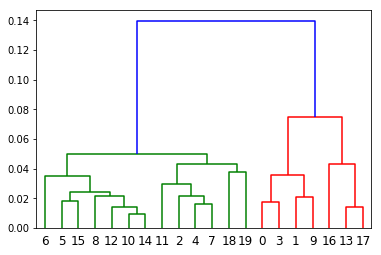

In [67]:
dendrogram(Z);

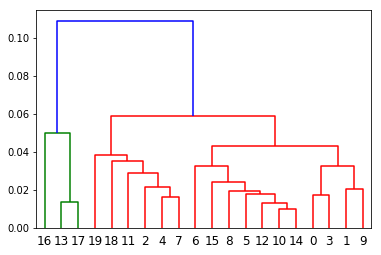

In [19]:
dendrogram(Z_complete);

In [23]:
dtw_clusters

,cluster
meter_id_1,
10,2
51,2
52,1
60,2
81,1
86,1
89,1
104,1
113,1


In [24]:
dtw_clusters_complete

,cluster
meter_id_1,
10,3
51,3
52,2
60,3
81,2
86,3
89,3
104,2
113,3


Population of each cluster:

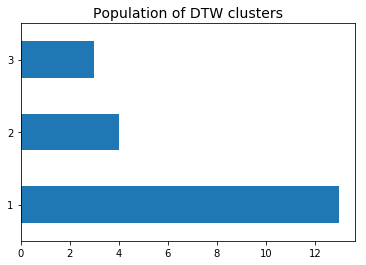

In [69]:
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title("Population of DTW clusters", fontsize = 14);

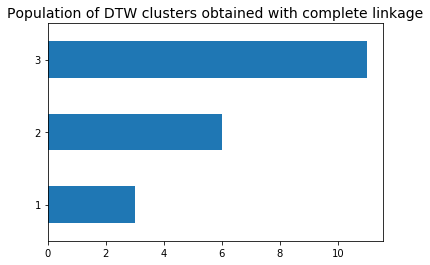

In [25]:
dtw_clusters_complete.cluster.value_counts().sort_index().plot.barh()
plt.title("Population of DTW clusters obtained with complete linkage", fontsize = 14);

Plot time-series from a 1st cluster obtained with Ward's linkage:

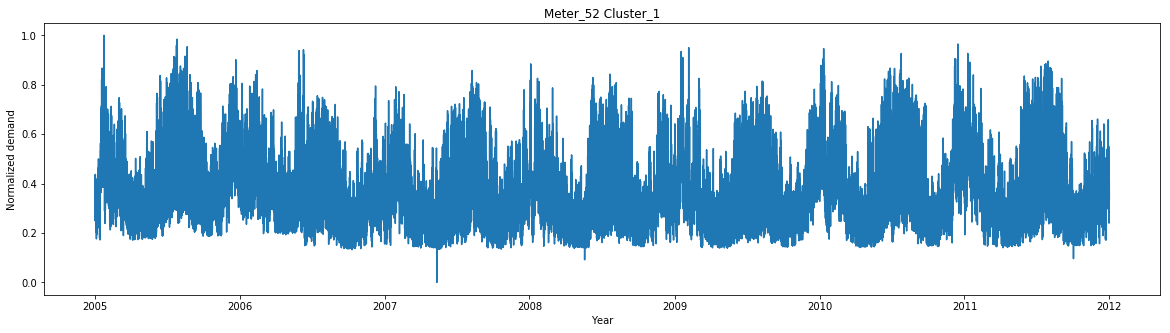

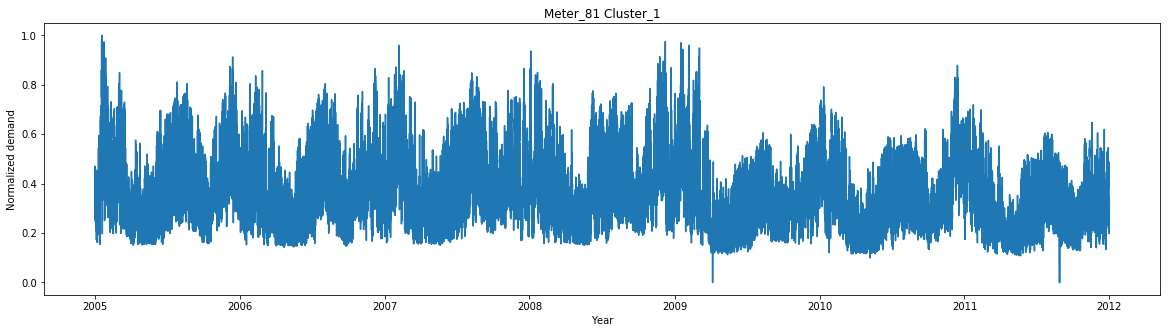

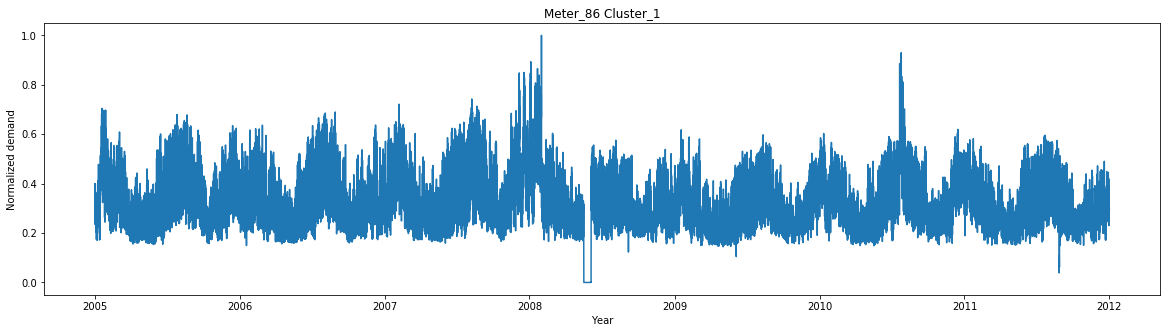

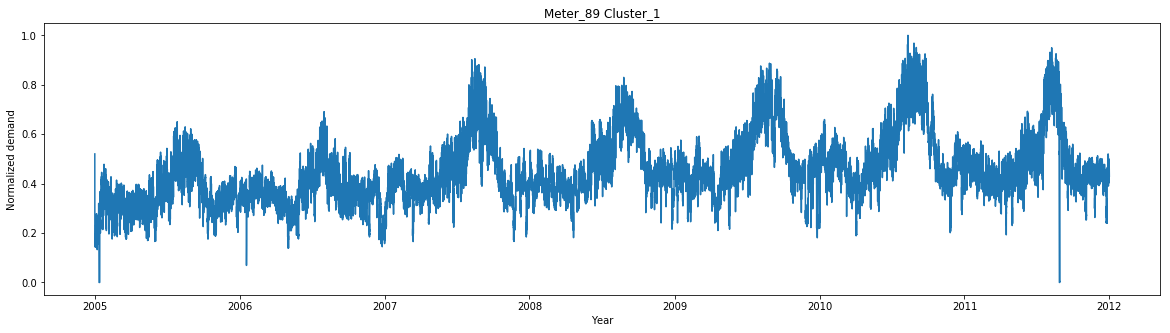

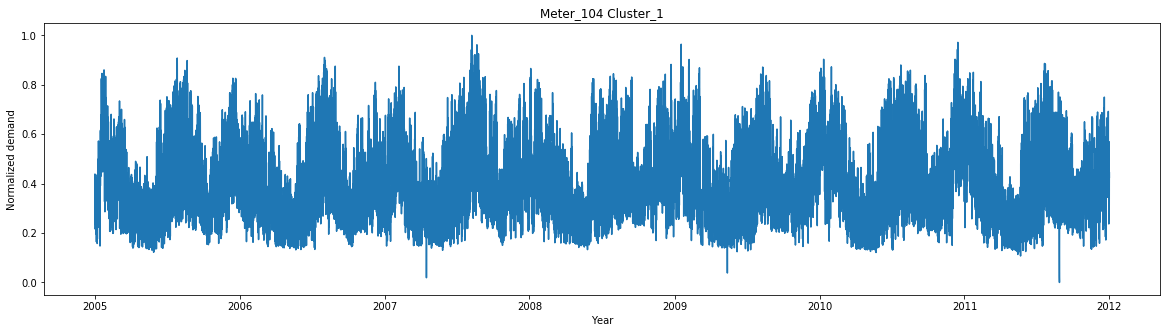

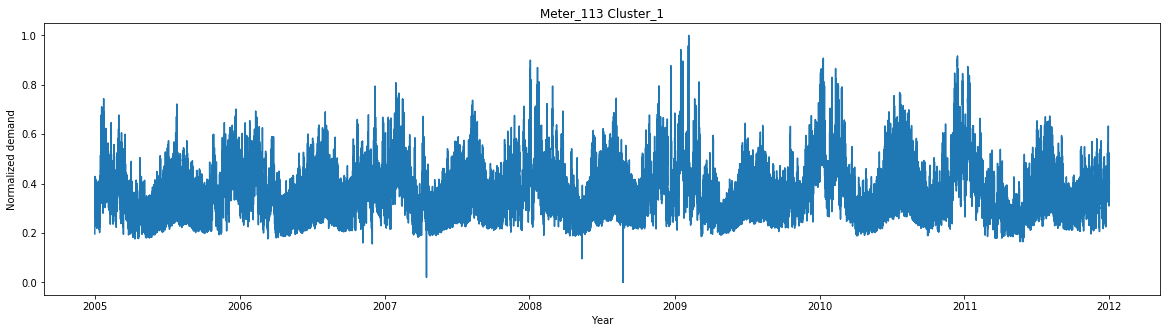

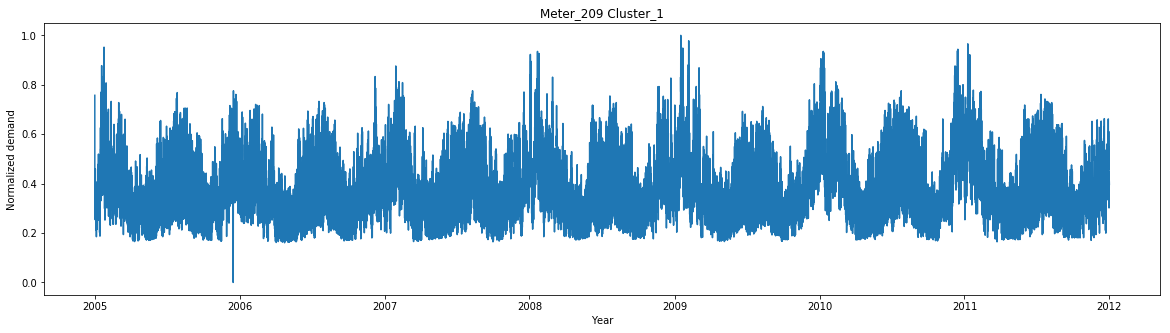

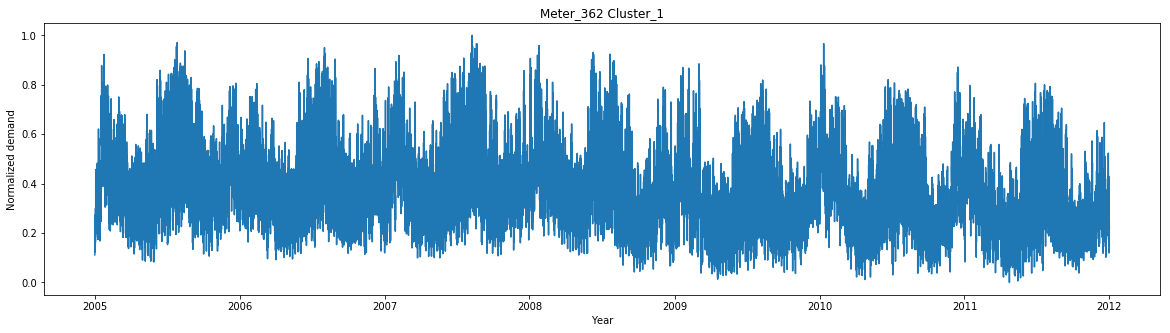

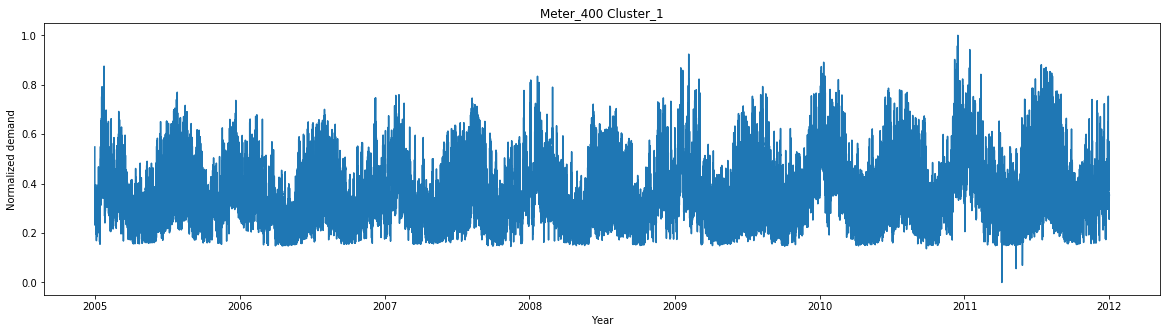

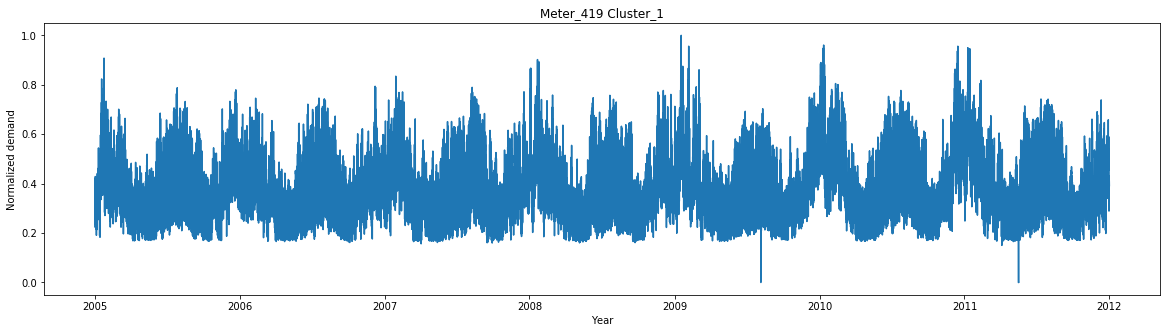

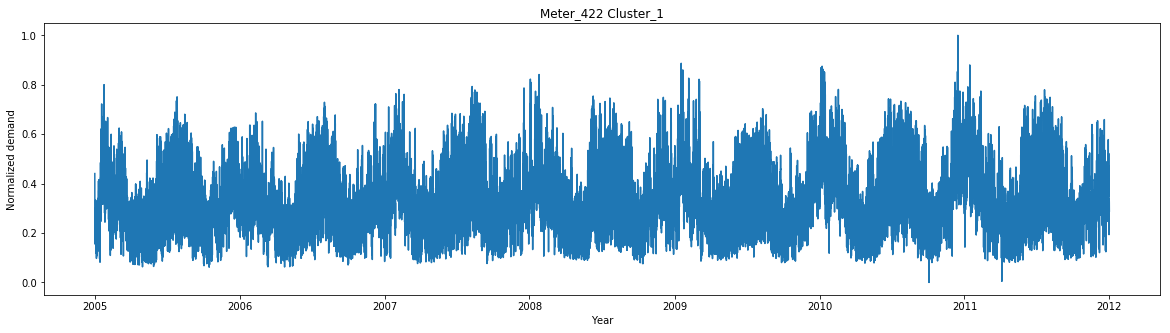

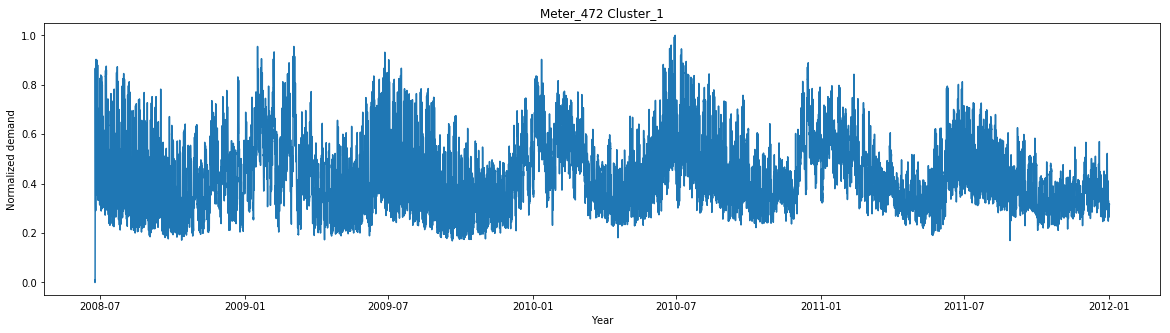

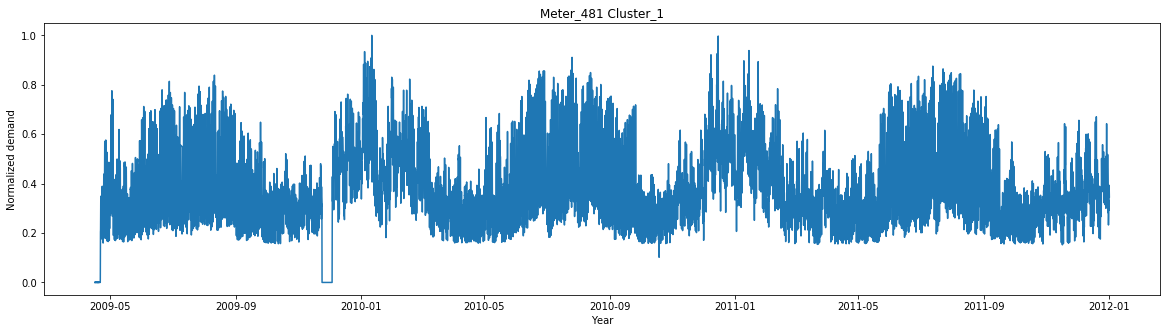

In [70]:
for i in dtw_clusters.loc[dtw_clusters.cluster == 1].index.values:
    plt.figure(figsize=(20,5))
    plt.plot(df[df.meter_id==i].date, df[df.meter_id==i].normalized_demand)
    plt.xlabel('Year')
    plt.ylabel('Normalized demand')
    plt.title('Meter_'+i.astype(str)+' Cluster_1')
    plt.show()

Plot time-series from a 2nd cluster obtained with a Ward's linkage:

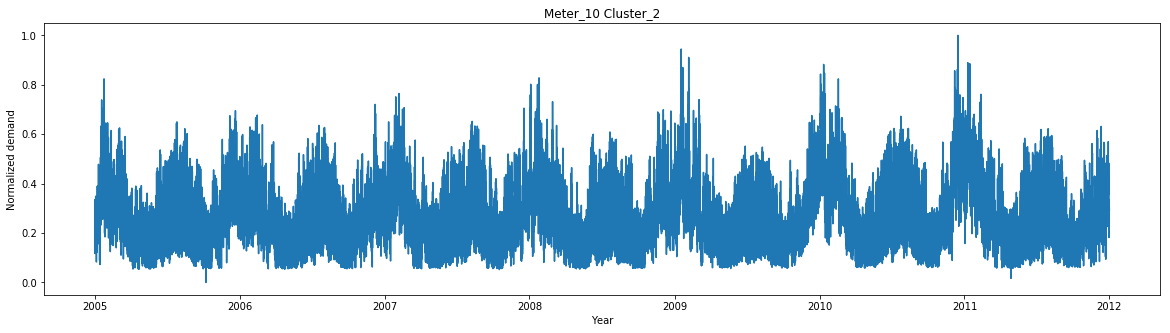

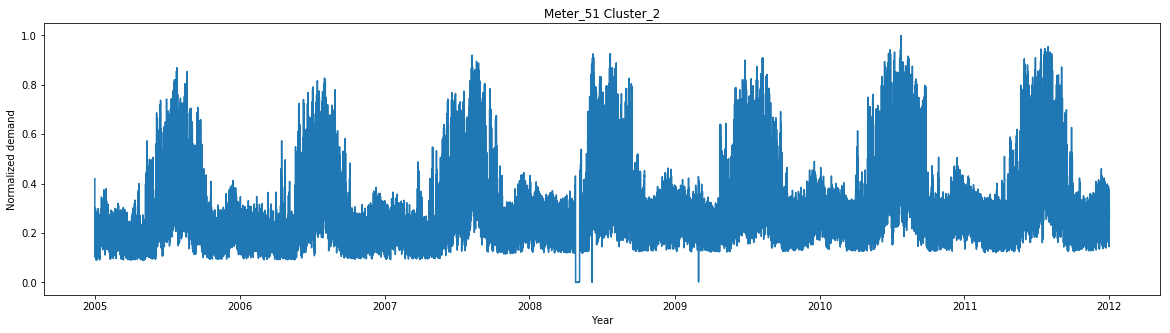

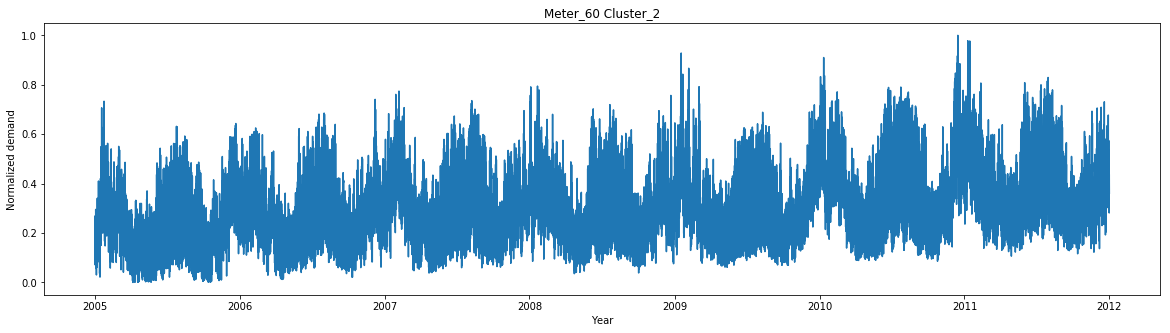

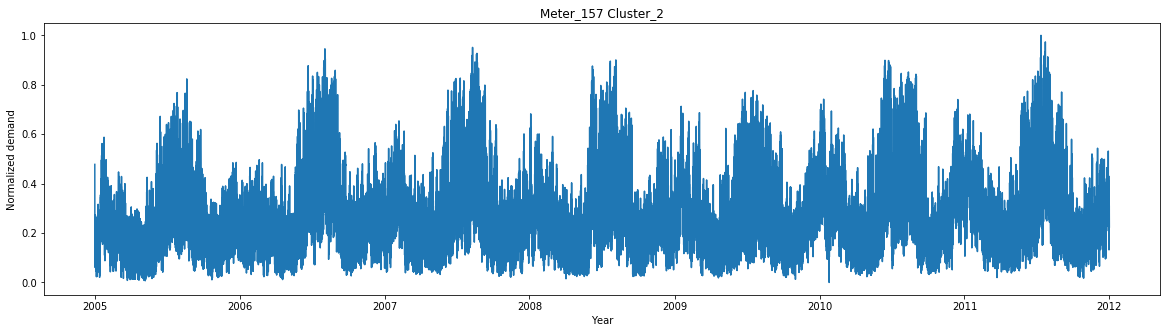

In [71]:
for i in dtw_clusters.loc[dtw_clusters.cluster == 2].index.values:
    plt.figure(figsize=(20,5))
    plt.plot(df[df.meter_id==i].date, df[df.meter_id==i].normalized_demand)
    plt.xlabel('Year')
    plt.ylabel('Normalized demand')
    plt.title('Meter_'+i.astype(str)+' Cluster_2')
    plt.show()

Plot time-series from a 3rd cluster obtained with a Ward's linkage:

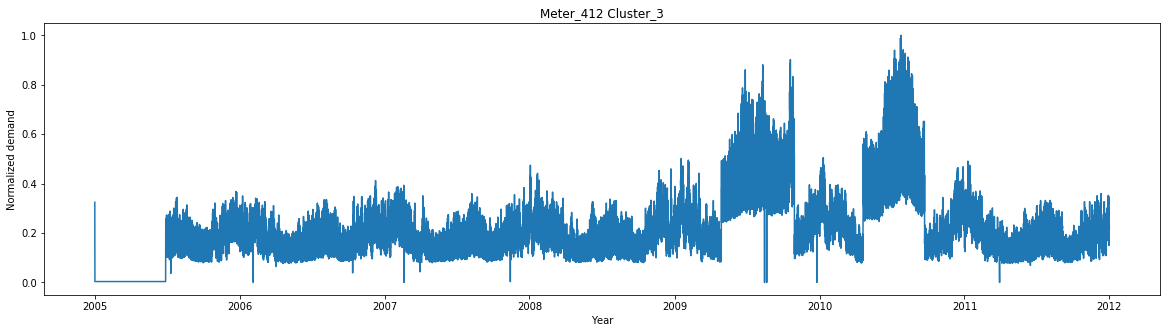

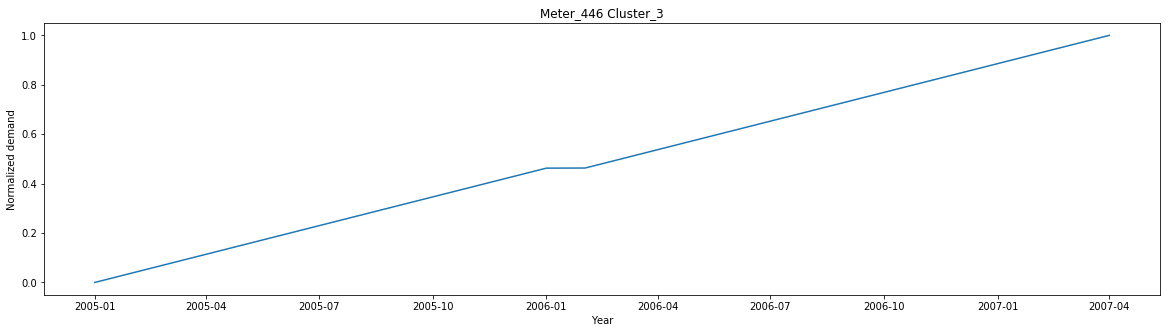

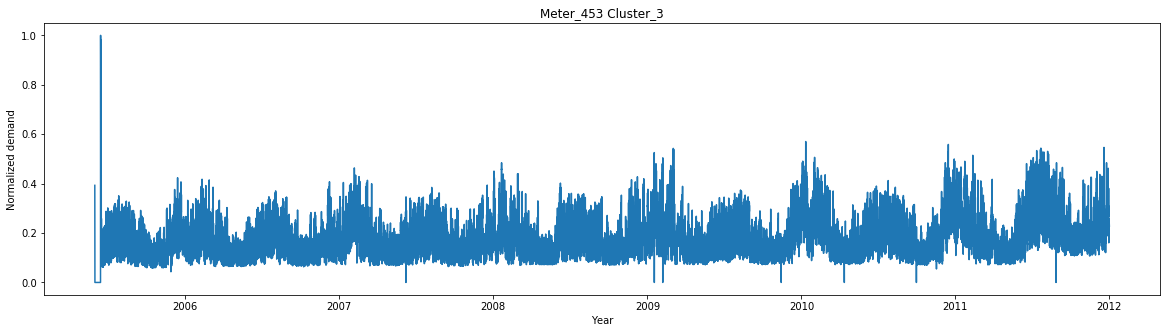

In [72]:
for i in dtw_clusters.loc[dtw_clusters.cluster == 3].index.values:
    plt.figure(figsize=(20,5))
    plt.plot(df[df.meter_id==i].date, df[df.meter_id==i].normalized_demand)
    plt.xlabel('Year')
    plt.ylabel('Normalized demand')
    plt.title('Meter_'+i.astype(str)+' Cluster_3')
    plt.show()

Plot time-series from the 1st cluster obtained with the complete linkage:

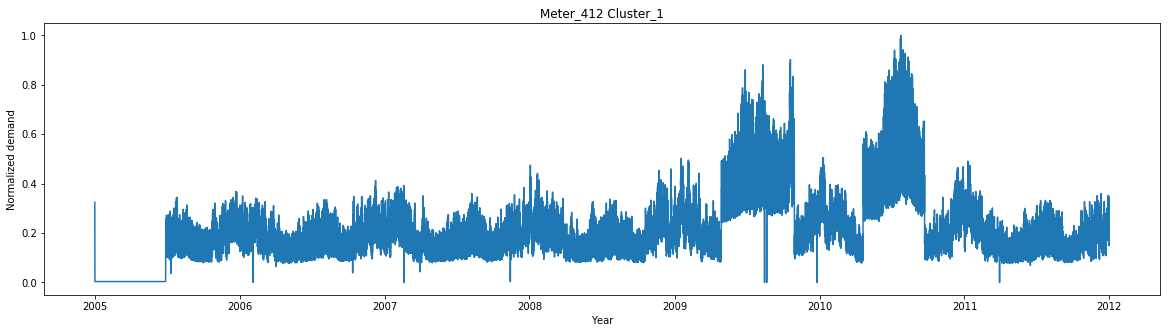

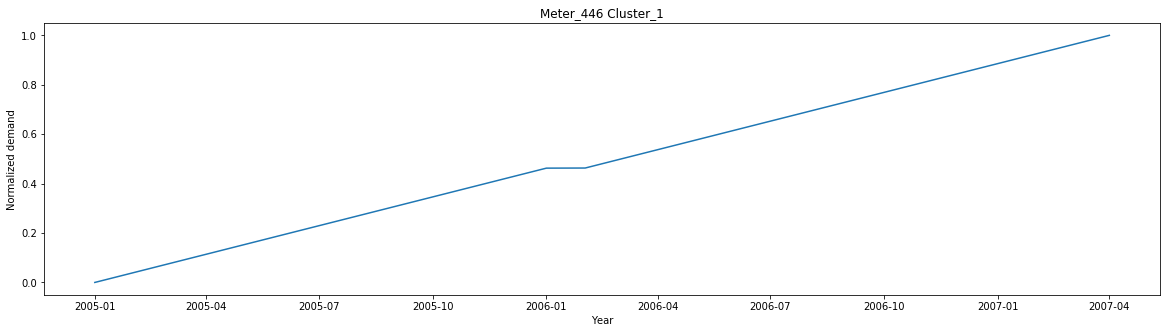

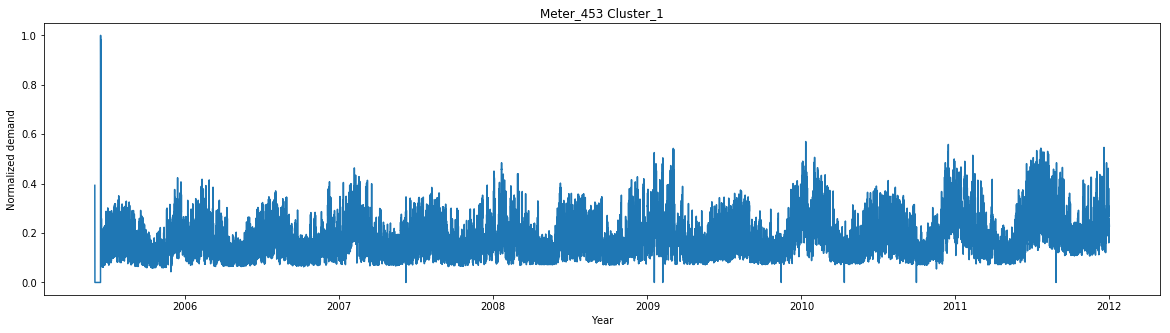

In [26]:
for i in dtw_clusters_complete.loc[dtw_clusters_complete.cluster == 1].index.values:
    plt.figure(figsize=(20,5))
    plt.plot(df[df.meter_id==i].date, df[df.meter_id==i].normalized_demand)
    plt.xlabel('Year')
    plt.ylabel('Normalized demand')
    plt.title('Meter_'+i.astype(str)+' Cluster_1')
    plt.show()

Plot time-series from the 2nd cluster obtained with the complete linkage:

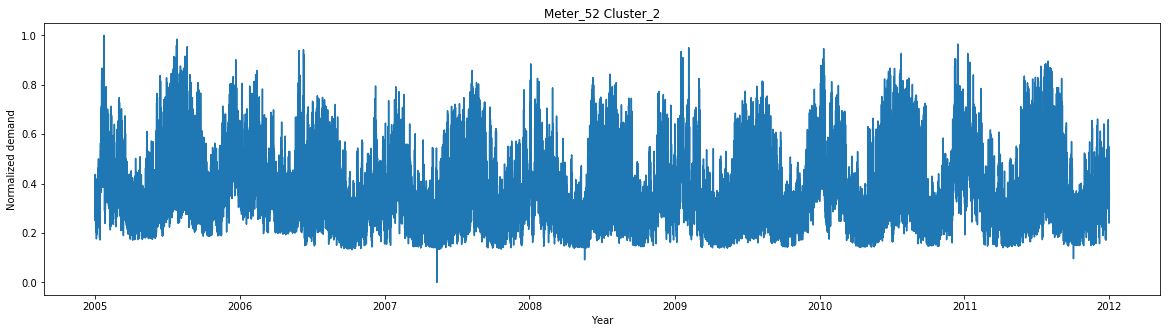

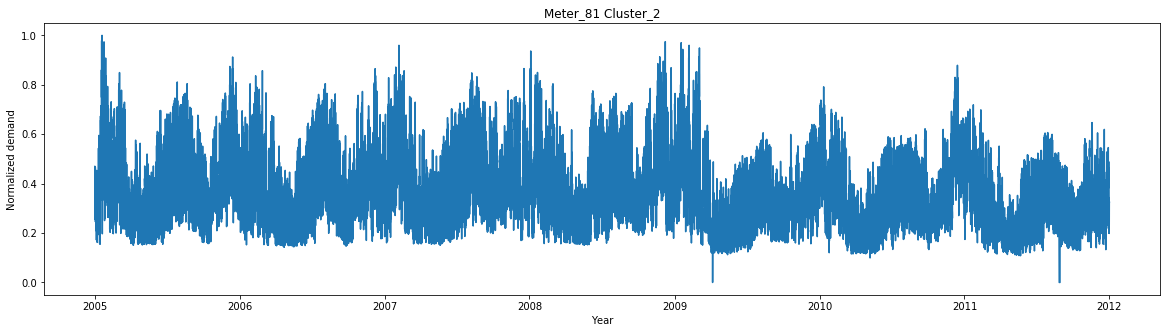

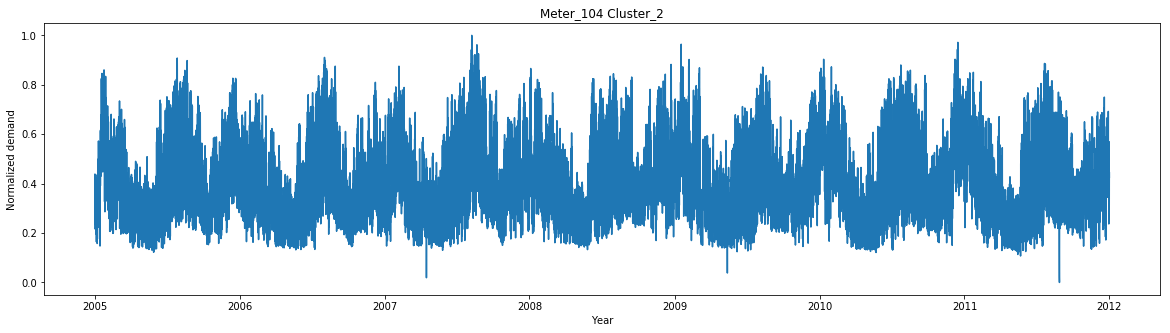

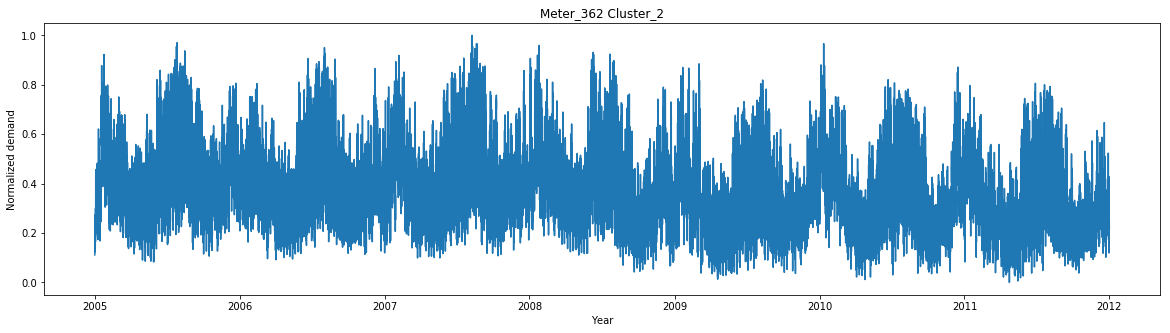

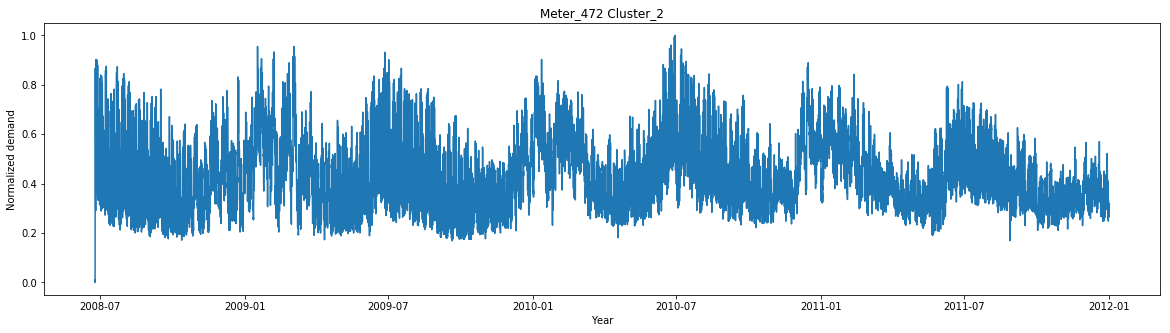

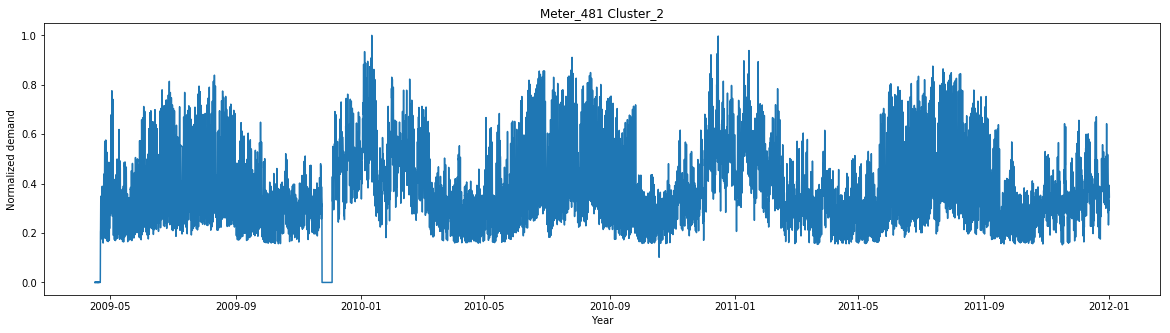

In [28]:
for i in dtw_clusters_complete.loc[dtw_clusters_complete.cluster == 2].index.values:
    plt.figure(figsize=(20,5))
    plt.plot(df[df.meter_id==i].date, df[df.meter_id==i].normalized_demand)
    plt.xlabel('Year')
    plt.ylabel('Normalized demand')
    plt.title('Meter_'+i.astype(str)+' Cluster_2')
    plt.show()

When using Ward's or complete linkage, the population of one cluster (3rd cluster computed with Ward's linkage and 1st cluster computed with complete linkage) remains the same, it includes time-series whose shape differs the most from the standard pattern observed. Time-series in other two clusters share very similar shapes.

Save the set of time-series with assigned clusters computed with Ward's linkage for further modelling:

In [44]:
dtw_clusters.to_pickle('dtw_clusters')